In [1]:
import openml

In [2]:
benchmark_suite = openml.study.get_suite('OpenML-CC18') # obtain the benchmark suite

benchmark_suite

OpenML Benchmark Suite
ID..............: 99
Name............: OpenML Benchmarking Suites and the OpenML-CC18
Status..........: in_preparation
Main Entity Type: task
Study URL.......: https://www.openml.org/s/99
# of Data.......: 72
# of Tasks......: 72
Creator.........: https://www.openml.org/u/1
Upload Time.....: 2019-02-21 18:47:13

In [3]:
%pylab inline
from pycpd import AffineRegistration
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [4]:
import pandas as pd

df = pd.read_csv('php0iVrYT.csv');

data = df.values[:, :4].astype(int);
target = df.values[:, 4].astype(int);
d_name = np.array(df.columns[:4]);
t_name = np.array(df.columns[4]);

# Visualization

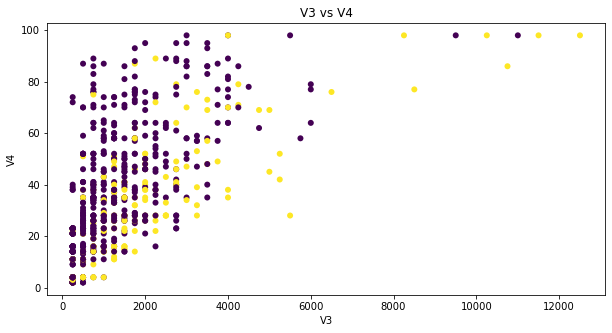

In [5]:
#plot two features
i, j = 2, 3;

plt.figure(figsize=(10,5));
plt.scatter(data[:,i], data[:,j], edgecolor='none', c=target);

xlabel(d_name[i]);
ylabel(d_name[j]);
title(d_name[i] + ' vs ' + d_name[j]);

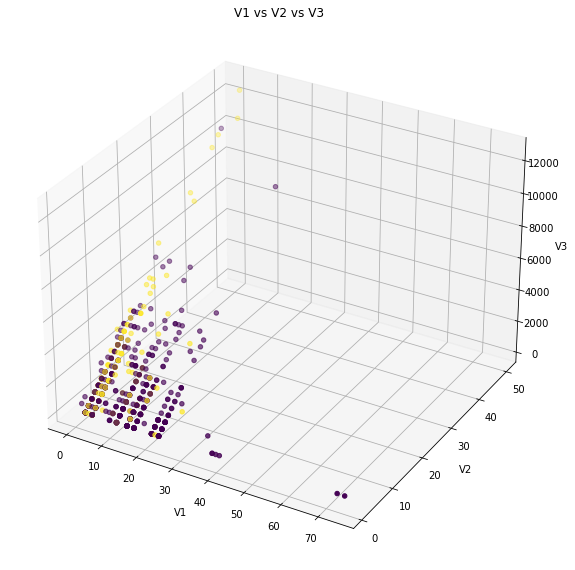

In [6]:
#plot three features
from mpl_toolkits.mplot3d import Axes3D
i,j,k = 0, 1, 2;

fig = plt.figure(figsize=(10,10));
ax = fig.add_subplot(111, projection = '3d');
ax.scatter(data[:,i], data[:,j], data[:,k], c=target);
ax.set_xlabel(d_name[i]);
ax.set_ylabel(d_name[j]);
ax.set_zlabel(d_name[k]);
ax.set_title(d_name[i] + ' vs ' + d_name[j] + ' vs ' + d_name[k], y=1.08);

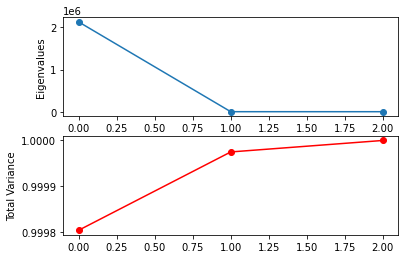

In [7]:
#explained variance
from sklearn.decomposition import PCA

X = data.copy();
pca = PCA(n_components = 3, whiten = False);
X = pca.fit_transform(X);

E, L = pca.components_.T, pca.explained_variance_

subplot(211);
plot(L,'o-');
ylabel('Eigenvalues');

subplot(212);
cl = np.cumsum(L);
plot(cl/cl[-1],'o-r');
ylabel('Total Variance');

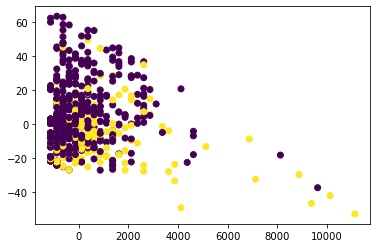

In [8]:
#plot 
scatter(X[:,0], X[:,1], c=target)

# Functions

In [9]:
def rotate_dist(X, theta_rotation=0, dimension=[0,1]):
    #dimensions to rotate
    Z = X[:, dimension]
    
    #rotation
    c, s = np.cos(theta_rotation), np.sin(theta_rotation)
    R = np.array([[c, -s], [s, c]])
    Z = (R @ Z.T).T
    
    #recombine
    X[:, dimension] = Z
    
    return X

In [10]:
def split_task(X, y):
    D = np.hstack((X, y))
    np.random.shuffle(D)
    
    n,_ = np.shape(D)
    m = int(n/2)
    D1 = D[:m, :]
    D2 = D[m:, :]
    
    X1 = D1[:, :-1]
    X2 = D2[:, :-1]
    
    y1 = D1[:, -1]
    y2 = D2[:, -1]
    
    return X1, y1, X2, y2

In [11]:
X1, y1, X2, y2 = split_task(X, target[:, np.newaxis])

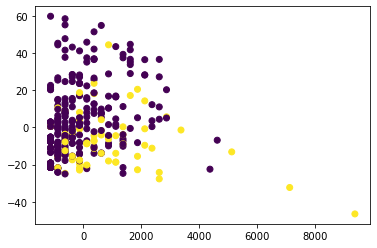

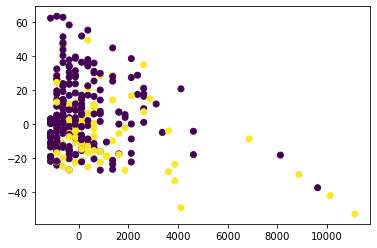

In [12]:
#plot
figure(1)
scatter(X1[:,0], X1[:,1], c=y1)

#plot
figure(2)
scatter(X2[:,0], X2[:,1], c=y2)

In [13]:
np.shape(X)

(748, 3)

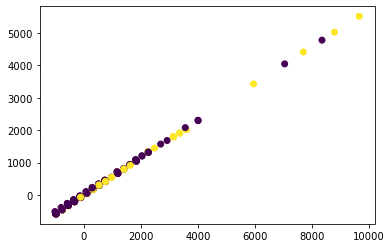

In [14]:
X2 = rotate_dist(X2, theta_rotation= np.pi/6, dimension=[0,1])

scatter(X2[:,0], X2[:,1], c=y2)

In [15]:
def cpd_reg(template, target, max_iter=50):    
    registration = AffineRegistration(X=target, Y=template, max_iterations=max_iter)
    deformed_template = registration.register(template)
    
    return deformed_template[0]

In [16]:
X3, y3 = cpd_reg(X2.copy(), X1.copy(), max_iter=50), y2.copy()

(-1657.7732675019643,
 10114.766304819726,
 -8.085439656850262,
 14.681269176163408)

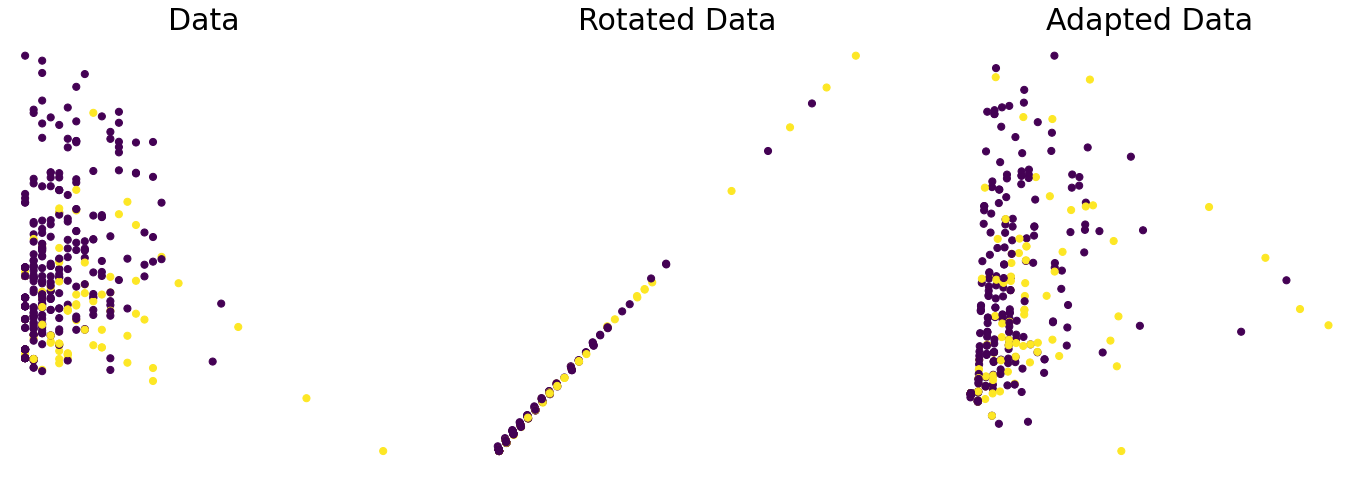

In [19]:
colors = sns.color_palette('Dark2', n_colors=2)

fig, ax = plt.subplots(1,3, figsize=(24,8))

ax[0].scatter(X1[:, 0], X1[:, 1], c=y1, s=50)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title('Data', fontsize=30)
ax[0].axis('off')

ax[1].scatter(X2[:, 0], X2[:, 1], c=y2, s=50)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title('Rotated Data', fontsize=30)
ax[1].axis('off')

ax[2].scatter(X3[:, 0], X3[:, 1], c=y3, s=50)
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_title('Adapted Data', fontsize=30)
ax[2].axis('off')
